In [1]:
import sys
if 'google.colab' in sys.modules:
    from google.colab import drive
    import os

    drive.mount('/content/drive')
    os.chdir('/content/drive/Shareddrives/Confidence Probes/taskdiscovery')
    !pip3 install transformer_lens fancy_einsum einops datasets encoders plotly circuitsvis

else:
    print("Not running in Google Colab, skipping installation of requirements.")

Not running in Google Colab, skipping installation of requirements.


In [2]:
import sys
# del sys.modules["data"]

In [149]:
from transformer_lens import HookedTransformer
from data import load_ICL_dataset,word_pairs_to_prompt_data,create_prompt,FVDataset
from torch.utils.data import DataLoader
from fancy_einsum import einsum
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from torch.nn import functional as F
from functools import partial
import numpy as np
import seaborn as sns
import torch
import math
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.cluster import KMeans
import random
import os

In [4]:
model_name = "gpt2-small"
device = torch.device("cuda")
model = HookedTransformer.from_pretrained(model_name, device=device)
tokenizer = model.tokenizer

/home/maxli/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:628: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


Loaded pretrained model gpt2-small into HookedTransformer


In [15]:
d = {"prompt":[], "label": [], "task" : []}
for task in os.listdir("function_vectors_data/abstractive"):
    task = task.replace(".json", "")
    dataset = load_ICL_dataset(task)

    if task == 'present-past' or task == 'capitalize':
        print(len(dataset['train']))
        print(len(dataset['test']))

    for test_pair in dataset['test']:
        for i in range(20):
            choices = random.choices(dataset['train'],k=5)
            word_pairs = {"input": [x["input"] for x in choices],
                        "output": [x["output"] for x in choices]}
            prompt_data = word_pairs_to_prompt_data(word_pairs, query_target_pair=test_pair, prepend_bos_token=True)
            sentence = create_prompt(prompt_data)
            d["prompt"].append(sentence)
            d["label"].append(test_pair["output"])
            d["task"].append(task)

df = pd.DataFrame(d)
df_subset = df[df["task"].isin(["present-past", "capitalize"])]
df_subset

569
170
205
61


,prompt,label,task
0,<|endoftext|>Q: pasta\nA: Pasta\n\nQ: lettuce\...,Mantis,capitalize
1,<|endoftext|>Q: vulture\nA: Vulture\n\nQ: anal...,Mantis,capitalize
2,<|endoftext|>Q: at\nA: At\n\nQ: duck\nA: Duck\...,Mantis,capitalize
3,<|endoftext|>Q: practice\nA: Practice\n\nQ: st...,Mantis,capitalize
4,<|endoftext|>Q: marker\nA: Marker\n\nQ: with\n...,Mantis,capitalize
...,...,...,...
59575,<|endoftext|>Q: finish\nA: finished\n\nQ: depe...,treated,present-past
59576,<|endoftext|>Q: leave\nA: left\n\nQ: include\n...,treated,present-past
59577,<|endoftext|>Q: use\nA: used\n\nQ: validate\nA...,treated,present-past
59578,<|endoftext|>Q: finish\nA: finished\n\nQ: mani...,treated,present-past


In [35]:
included_tasks = ['present-past', 'capitalize']

min_len = 10000
for task in included_tasks: 
    task_set = df[df["task"] == task]
    if len(task_set) < min_len:
        min_len = len(task_set)

print("data points per task", min_len)

task_dfs = []
for task in included_tasks:
    task_set = df[df["task"] == task].copy().reset_index()
    task_dfs.append(task_set.iloc[np.random.choice(len(task_set), min_len)])

df_subset = pd.concat(task_dfs)

data points per task 1220


In [36]:
df.task.unique()

array(['capitalize', 'landmark-country', 'person-instrument',
       'national_parks', 'word_length', 'synonym', 'ag_news',
       'present-past', 'next_item', 'sentiment', 'english-spanish',
       'english-french', 'person-sport', 'product-company',
       'english-german', 'antonym', 'park-country', 'country-currency',
       'commonsense_qa', 'country-capital', 'prev_item',
       'singular-plural', 'lowercase_last_letter', 'next_capital_letter',
       'capitalize_second_letter', 'lowercase_first_letter',
       'person-occupation', 'capitalize_last_letter',
       'capitalize_first_letter'], dtype=object)

In [47]:
tokenized_data = []
for ln in df_subset['prompt']:
    x = tokenizer(ln, max_length=64, truncation=True, padding='max_length', return_tensors="pt")
    if x['attention_mask'][-1,-1] == 1:
        continue
    tokenized_data.append(x)

In [49]:

dataset = FVDataset(tokenized_data, df_subset['task'].to_numpy(), df_subset['label'].to_numpy())

batch_size = 1
dl = DataLoader(dataset, batch_size=batch_size, shuffle=False,drop_last=True)

In [50]:
tokenizer.batch_decode(next(iter(dl))[0])

/home/maxli/taskdiscovery/data.py:558: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(input_ids, dtype=torch.long)
/home/maxli/taskdiscovery/data.py:559: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attention_mask = torch.tensor(attention_mask, dtype=torch.long)


['<|endoftext|>Q: gather\nA: gathered\n\nQ: fasten\nA: fastened\n\nQ: revise\nA: revised\n\nQ: model\nA: modelled\n\nQ: trust\nA: trusted\n\nQ: calculate\nA:<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>']

In [97]:
model.cfg.use_attn_result = True
n_layers = 12

def save_(save_to, result, hook):
  save_to.append(result)
  return result

def attn_filter(name):
  return name.endswith("attn.hook_result")

def pattern_filter(name):
  return name.endswith("pattern")

def pre_filter(name):
  return name.endswith("resid_pre")


attention_results = 0
all_activations = []
tasks = []
entropies = []
corrects= 0

mean_samples = 0

for batch in tqdm(dl):
  with torch.no_grad():
    attn_storage = []
    act_storage = []
    pattern_storage = []
    attn_mask =  batch[1]
    # batch x tokens x vocab size
    output = model.run_with_hooks(
                    batch[0],
                    attention_mask = batch[1],
                    fwd_hooks=[(attn_filter,partial(save_, attn_storage),) ] +
                    [(pre_filter,partial(save_, act_storage),) ] +
                    [(pattern_filter,partial(save_, pattern_storage),) ]


            )

    # will return a tensor with shape batch size with indices of last token
    last_token_idx = attn_mask.cumsum(1).argmax(1)

    activations = torch.stack(act_storage)[:, torch.arange(batch_size), last_token_idx, :]
    all_activations.append(activations.cpu())

    mean_samples += attn_mask[:,1:].sum()

    # attn_mask: [bsz, seq_pos]
    # attn_storage: [n_layers, bsz, seq_pos, n_heads, d_model]
    attention_results += (torch.stack(attn_storage, dim=0) * attn_mask.unsqueeze(-1).unsqueeze(-1).to(device))[:,1:].sum(dim=[1,2]).cpu()
    
    labels = batch[-1]
    tasks += list(batch[2])

    predicted_labels = tokenizer.batch_decode(output[torch.arange(batch_size), last_token_idx,:].argmax(-1))

    for label,predicted_label in zip(labels,predicted_labels):
      if label.startswith(predicted_label.strip()):
        corrects += 1

    patterns = torch.stack(pattern_storage).permute(0,2,1,3,4)[:,:,torch.arange(batch_size), last_token_idx, :].permute(2,0,1,3)
    entropy = (- patterns * (patterns + 1e-10).log()).sum(-1).flatten(1,2)
    entropies.append(entropy.cpu())

    # print(list(batch[2]),
    #       tokenizer.decode(batch[0][torch.arange(batch_size), last_token_idx-3 ]),
    #       tokenizer.batch_decode(output[torch.arange(batch_size), last_token_idx,:].argmax(-1)))

  0%|          | 0/2413 [00:00<?, ?it/s]/home/maxli/taskdiscovery/data.py:558: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(input_ids, dtype=torch.long)
/home/maxli/taskdiscovery/data.py:559: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attention_mask = torch.tensor(attention_mask, dtype=torch.long)
100%|██████████| 2413/2413 [01:18<00:00, 30.75it/s]


In [98]:
entropies = torch.cat(entropies,0)
# n_layers x 1 x tokens x heads x d_model

In [99]:
mean_attn = (attention_results/mean_samples).to(device)
all_activations = torch.cat(all_activations, 1)
print(all_activations.shape)

torch.Size([12, 2413, 768])


In [100]:
def train_test_split(x,y, train_pct=0.8):
    if x.shape[0] != y.shape[0]:
        print("shapes do not match")
        return
    idx = math.floor(y.shape[0] * train_pct)
    return x[:idx], y[:idx], x[idx:], y[idx:]

In [144]:
def pca_project(x, dim, weighted=True):
    xv = x
    if not weighted: 
        xv = x / x.var(0)
    u, d, v = torch.pca_lowrank(xv,dim+10)
    return torch.matmul(x,v[:,:dim])

In [102]:
def fit_cluster(x):
    label_encoder = LabelEncoder()
    true_labels = label_encoder.fit_transform(tasks)

    train_x, train_y, test_x, test_y = train_test_split(x, true_labels)

    kmeans = KMeans(n_clusters=2,n_init =10, random_state=0).fit(train_x)

    predicted_labels = kmeans.labels_

    if np.mean(predicted_labels == train_y) < 0.5:
        predicted_labels = 1 - predicted_labels

    # Calculate "accuracy"
    accuracy = accuracy_score(train_y, predicted_labels)
    print(f"train accuracy: {accuracy}")

    test_predict = kmeans.predict(test_x)
    if np.mean(test_predict == test_y) < 0.5:
        test_predict = 1 - test_predict

    # Calculate "accuracy"
    test_accuracy = accuracy_score(test_y, test_predict)
    print(f"test accuracy: {test_accuracy}")

    return accuracy, test_accuracy

In [120]:
fit_cluster(entropies)
fit_cluster(pca_project(entropies,20))

train accuracy: 0.9813471502590674
test accuracy: 0.9565217391304348
train accuracy: 0.9813471502590674
test accuracy: 0.9565217391304348


(0.9813471502590674, 0.9565217391304348)

In [105]:
for layer in range(n_layers):
  x = all_activations[layer]
  print(f"Layer {layer}")
  fit_cluster(x)  
  print(f"Layer {layer} pca")
  fit_cluster(pca_project(x,50))

Layer 0
train accuracy: 0.8694300518134715
test accuracy: 0.6915113871635611
Layer 0 pca
train accuracy: 0.9549222797927461
test accuracy: 0.8964803312629399
Layer 1
train accuracy: 0.9880829015544041
test accuracy: 0.968944099378882
Layer 1 pca
train accuracy: 0.9880829015544041
test accuracy: 0.9813664596273292
Layer 2
train accuracy: 0.9823834196891191
test accuracy: 0.9544513457556936
Layer 2 pca
train accuracy: 0.983419689119171
test accuracy: 0.9585921325051759
Layer 3
train accuracy: 0.9476683937823834
test accuracy: 0.8778467908902692
Layer 3 pca
train accuracy: 0.949740932642487
test accuracy: 0.8737060041407867
Layer 4
train accuracy: 0.9202072538860103
test accuracy: 0.7867494824016563
Layer 4 pca
train accuracy: 0.9155440414507772
test accuracy: 0.7598343685300207
Layer 5
train accuracy: 0.8948186528497409
test accuracy: 0.7184265010351967
Layer 5 pca
train accuracy: 0.8932642487046633
test accuracy: 0.7122153209109731
Layer 6
train accuracy: 1.0
test accuracy: 1.0
Layer 6 

In [122]:
attention_scores = []


# n_heads * batch_size x tokens x n_heads x dim
# [i ,:,i,:] will be 1s
seq_len = 64
mask = torch.eye(12,device = device).unsqueeze(1).unsqueeze(-1).bool()
mask = mask.expand(-1, seq_len - 1, -1, 768).repeat_interleave(batch_size,dim=0)

def attn_mean_ablation(mean, result, hook):
  n_heads = model.cfg.n_heads
  result[-n_heads * batch_size:,1:] = torch.where(mask, mean.unsqueeze(0).unsqueeze(0).repeat(n_layers*batch_size,seq_len-1,1,1).to(device), result[-n_layers* batch_size:,1:])
  return result

def increase_batch(act,hook):
  return torch.cat([act,act[:batch_size].repeat(n_layers,1,1)],0)

def attn_filter_layer(i,name):
  return name.endswith(f"{i}.attn.hook_result")

def pre_filter(name):
  return name.endswith("resid_pre")


idx = 0
d
kls = []
tasks = []

for batch in tqdm(dl):
  with torch.no_grad():

    output = model.run_with_hooks(
                    batch[0],
                    attention_mask = batch[1],
                    fwd_hooks=[(partial(attn_filter_layer,i),partial(attn_mean_ablation, mean_attn[i]),)  for i in range(n_layers)] +
                    [(pre_filter,increase_batch)]
            )

    attn_mask = batch[1]
    last_token_idx = attn_mask.cumsum(1).argmax(1)
    output = output.unflatten(0,(-1,batch_size))
    output = output[:,torch.arange(batch_size), last_token_idx,:]

    kl_loss = F.kl_div(output[1:].softmax(-1).log(), output[0:1].softmax(-1), reduction = 'none').sum(-1).T

    kls.append(kl_loss.cpu().numpy())
    tasks+= list(batch[2])
    # print(tokenizer.decode(batch[0].squeeze()) ,tokenizer.decode(output.argmax(-1)[0]))

    idx += 1
 

100%|██████████| 2413/2413 [22:05<00:00,  1.82it/s]


In [157]:
def fit_linreg(x):
    label_encoder = LabelEncoder()
    true_labels = label_encoder.fit_transform(tasks)

    train_x, train_y, test_x, test_y = train_test_split(x, true_labels)

    lm = LogisticRegression(random_state=0).fit(train_x, train_y)

    predicted_labels = lm.predict(train_x)

    # Calculate "accuracy"
    accuracy = accuracy_score(train_y, predicted_labels)
    print(f"train accuracy: {accuracy}")

    test_predict = lm.predict(test_x)

    # Calculate "accuracy"
    test_accuracy = accuracy_score(test_y, test_predict)
    print(f"test accuracy: {test_accuracy}")

    return accuracy, test_accuracy

In [127]:
importances = np.concatenate(kls,0)

In [145]:
fit_cluster(importances)
fit_cluster(pca_project(torch.tensor(importances), 10, weighted=False))

train accuracy: 0.6088082901554405
test accuracy: 0.7846790890269151
train accuracy: 0.7844559585492228
test accuracy: 0.6169772256728778


(0.7844559585492228, 0.6169772256728778)

In [142]:
pca_project(torch.tensor(np.log(importances)),1).shape

torch.Size([2413, 11])

<Axes: ylabel='Count'>

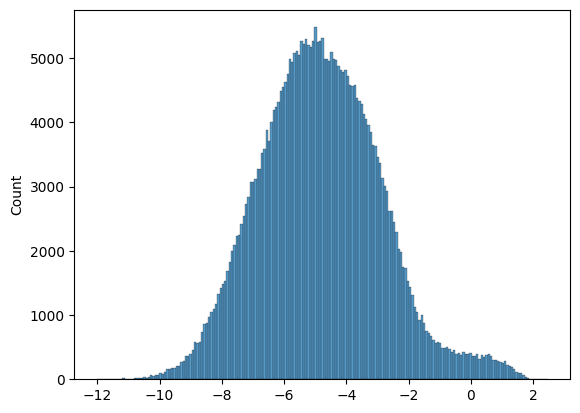

In [155]:
sns.histplot(np.log(importances.flatten()))

In [193]:
pca_reduced_impt = pca_project(torch.tensor(np.log(importances)), 3, weighted=False)

In [196]:
fit_cluster(np.log(importances))
fit_cluster(pca_reduced_impt)

train accuracy: 0.6124352331606218
test accuracy: 0.7867494824016563
train accuracy: 0.5813471502590674
test accuracy: 0.7991718426501035


(0.5813471502590674, 0.7991718426501035)

In [197]:
fit_linreg(np.log(importances))
fit_linreg(pca_reduced_impt)

train accuracy: 1.0
test accuracy: 1.0
train accuracy: 0.9979274611398964
test accuracy: 0.9917184265010351


(0.9979274611398964, 0.9917184265010351)

In [198]:
pca_reduced_impt.shape

torch.Size([2413, 3])

In [199]:
pca_reduced_impt[:,1]

tensor([ 3.6311,  0.4347,  3.5952,  ...,  9.8474, 12.6102,  8.3693])

<Axes: xlabel='None', ylabel='None'>

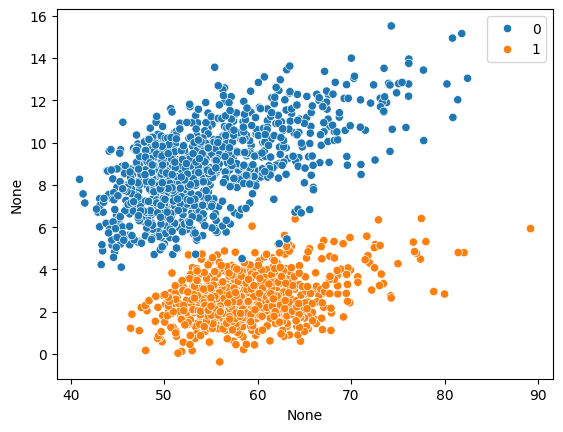

In [200]:
sns.scatterplot(x=pca_reduced_impt[:,0], y =pca_reduced_impt[:,1],hue=true_labels)

In [201]:
kmeans = KMeans(n_clusters=2,n_init =10, random_state=0).fit(pca_reduced_impt)
predicted_labels = kmeans.labels_

<Axes: xlabel='None', ylabel='None'>

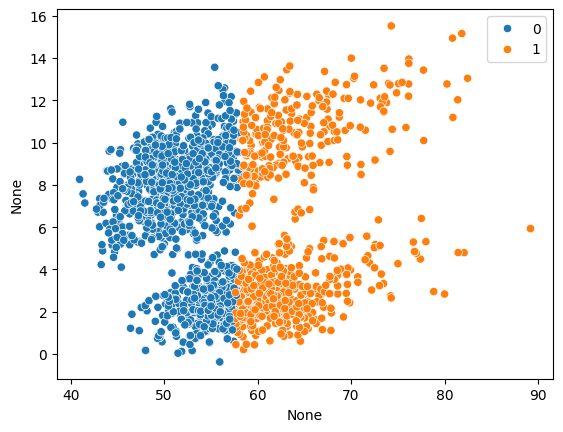

In [202]:
sns.scatterplot(x=pca_reduced_impt[:,0], y =pca_reduced_impt[:,1],hue=predicted_labels)

In [172]:
np.linalg.norm(np.log(importances), axis=-1)

array([57.94101 , 64.73528 , 63.35975 , ..., 57.7258  , 68.086815,
       57.094303], dtype=float32)

In [ ]:
def pca_project(x, dim, weighted=True):
    xv = x
    if not weighted: 
        xv = x / x.var(0)
    u, d, v = torch.pca_lowrank(xv,dim+10)
    return torch.matmul(x,v[:,:dim])

In [113]:
big_X.shape

(231, 144)

In [114]:
norm_X = (big_X - big_X.mean(0)) / big_X.var(0)

<Axes: ylabel='Count'>

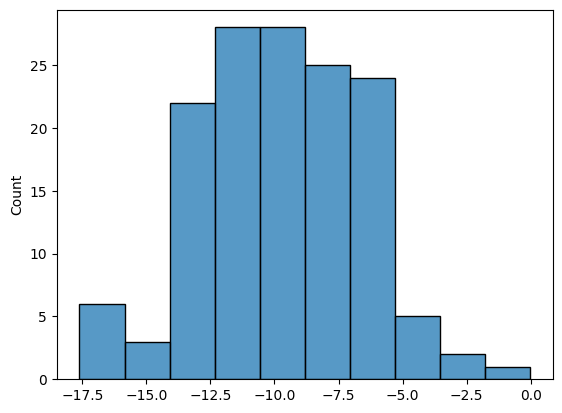

In [112]:
sns.histplot(np.log(big_X.var(0)))

In [86]:
(big_X < 1e-4).sum()

2538

In [110]:
big_X.var(0)

array([[1.1755037e-03, 1.3670120e+00, 1.8443628e-03, ..., 3.3018538e-03,
        2.7158054e-02, 1.6401056e-04],
       [1.3448875e-03, 1.8861841e+00, 1.1630161e-03, ..., 1.4595613e-03,
        3.2474864e-03, 1.5804169e-03],
       [1.9562722e-04, 3.1992290e+00, 2.5941050e-03, ..., 2.1240897e-03,
        6.9699949e-04, 9.6067414e-04],
       ...,
       [5.1921536e-03, 4.4849089e-01, 1.1895746e-03, ..., 1.5509469e-02,
        2.5116937e-04, 3.7080487e-03],
       [1.5250899e-02, 3.8596103e-01, 5.8716144e-03, ..., 2.6388790e-02,
        2.8858386e-02, 5.1989192e-03],
       [2.5181696e-03, 2.5367576e-01, 8.4232073e-04, ..., 4.4700980e-02,
        6.8214955e-05, 7.3381402e-03]], dtype=float32)

In [93]:
big_X+1e-8

array([[1.1755137e-03, 1.3670120e+00, 1.8443728e-03, ..., 3.3018638e-03,
        2.7158063e-02, 1.6402056e-04],
       [1.3448976e-03, 1.8861841e+00, 1.1630261e-03, ..., 1.4595713e-03,
        3.2474964e-03, 1.5804269e-03],
       [1.9563721e-04, 3.1992290e+00, 2.5941150e-03, ..., 2.1240998e-03,
        6.9700950e-04, 9.6068415e-04],
       ...,
       [5.1921634e-03, 4.4849089e-01, 1.1895846e-03, ..., 1.5509480e-02,
        2.5117939e-04, 3.7080587e-03],
       [1.5250909e-02, 3.8596103e-01, 5.8716242e-03, ..., 2.6388800e-02,
        2.8858395e-02, 5.1989290e-03],
       [2.5181796e-03, 2.5367576e-01, 8.4233074e-04, ..., 4.4700991e-02,
        6.8224952e-05, 7.3381499e-03]], dtype=float32)

In [99]:
data_ts = np.log(big_X+1e-6)

In [116]:
data_ts = norm_X

<Axes: ylabel='Count'>

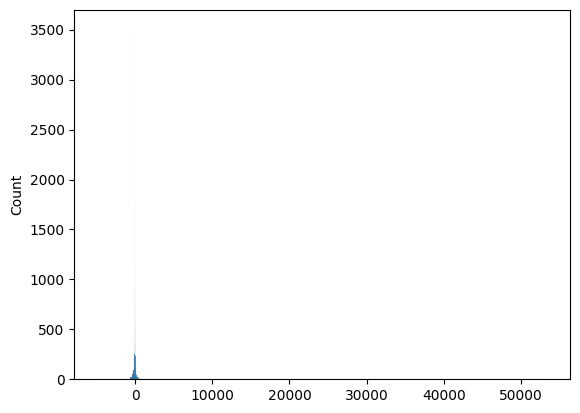

In [117]:
sns.histplot(data_ts.flatten())